In [5]:
#Importing needed packages
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

## Checking and cleaning data

In [6]:
df = pd.read_csv (r'C:\Users\patri\Downloads\CSVs\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
#Checking the control and user groups for any crossover/error
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [8]:
#Removing the users for control who saw the new page, and treatment who saw the old page
#df_clean = df.loc[df['group'] == 'control' & df['landing_page'] == 'old_page' | df['group'] == 'treatment' & df['landing_page'] == 'new_page']

In [9]:
#Filtering out the incorrect control/treatment instances
filter1 = df['group'] == 'control'
filter2 = df['landing_page'] == 'old_page'
filter3 = df['group'] == 'treatment'
filter4 = df['landing_page'] == 'new_page'
df_clean = df.loc[filter1 & filter2| filter3 & filter4]

In [10]:
#Checking the control and user groups again
df_clean.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [11]:
#Checking if there are any duplicated users
df_clean[df_clean.duplicated(subset = ['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#Removing the second instance of the duplicated user
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
df_clean.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Looking at the distribution

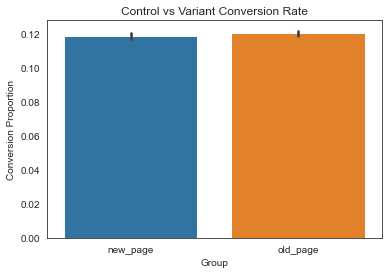

In [64]:
#Looking at a barplot to see the relative proportions of conversions
#Looking like the new page may have had less conversions
from matplotlib import rcParams
sns.set_style('white')
rcParams['figure.figsize'] = 6,4

_=sns.barplot(x='landing_page' , y='converted' , data=df_clean)
plt.title('Control vs Variant Conversion Rate')
plt.ylabel('Conversion Proportion')
plt.xlabel('Group')
plt.show()

## Exploration with dates

In [14]:
#Checking dtypes
df_clean.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [15]:
#Converting timestamp to datetime
import datetime as dt
df_clean['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_clean.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
#Checking the time period
df_clean['month_day'] = df_clean['timestamp'].dt.strftime('%m-%d')
df_clean.head()

,user_id,timestamp,group,landing_page,converted,month_day
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,01-21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,01-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,01-11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,01-08
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,01-21


In [17]:
#Putting in order by month_day to be able to graph, since I could not get the order argument to work
df_clean = df_clean.sort_values(by='month_day')
df_clean.head()

,user_id,timestamp,group,landing_page,converted,month_day
184831,929659,2017-01-02 14:41:58.848698,treatment,new_page,0,01-02
148281,779581,2017-01-02 16:31:51.186604,control,old_page,0,01-02
248721,740003,2017-01-02 17:11:05.168172,control,old_page,1,01-02
248722,823601,2017-01-02 23:41:20.188398,treatment,new_page,0,01-02
77133,845187,2017-01-02 18:13:49.064532,treatment,new_page,0,01-02


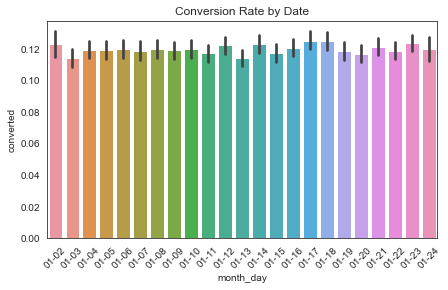

In [62]:
# can't seem to get order to work: order = df_clean.sort_values(by='month_day').month_day

rcParams['figure.figsize'] = 7,4

plt.title('Conversion Rate by Date')
plt.ylabel('Conversion Proportion')
plt.xlabel('Date')
_ = sns.barplot(x='month_day', y = 'converted', data=df_clean)
_ = plt.xticks(rotation = 45)
plt.show()

In [20]:
#Seeing trends over the week for trafic
#df_clean['weekday'] = dt.datetime(df_clean['timestamp']).weekday()

In [21]:
dt.datetime.today().weekday()

5

In [50]:
#Function to return day of week. Each instances is a timestamp, so we use pd.timestamp.weekday()
def to_weekday(x):
    if x.weekday() == 0:
        return 'Monday'
    if x.weekday() == 1:
        return 'Tuesday'
    if x.weekday() == 2:
        return 'Wednesday'
    if x.weekday() == 3:
        return 'Thursday'
    if x.weekday() == 4:
        return 'Friday'
    if x.weekday() == 5:
        return 'Saturday'
    if x.weekday() == 6:
        return 'Sunday'

In [51]:
#Testing on first element of timestamp column
to_weekday(df_clean['timestamp'][0])

'Saturday'

In [52]:
#Applying weekday to timestamp column
df_clean['weekday'] = df_clean.apply(lambda x: to_weekday(x['timestamp']), axis=1)

In [53]:
#Checking df
df_clean.head()

,user_id,timestamp,group,landing_page,converted,month_day,weekday
184831,929659,2017-01-02 14:41:58.848698,treatment,new_page,0,01-02,Monday
148281,779581,2017-01-02 16:31:51.186604,control,old_page,0,01-02,Monday
248721,740003,2017-01-02 17:11:05.168172,control,old_page,1,01-02,Monday
248722,823601,2017-01-02 23:41:20.188398,treatment,new_page,0,01-02,Monday
77133,845187,2017-01-02 18:13:49.064532,treatment,new_page,0,01-02,Monday


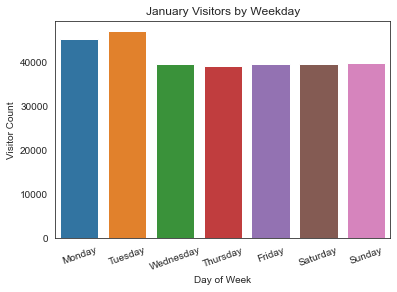

In [66]:
#plotting weekdays - See more traffic earlier in the week

rcParams['figure.figsize'] = 6,4

_=sns.countplot(x='weekday', data=df_clean)
plt.title('January Visitors by Weekday')
plt.ylabel('Visitor Count')
plt.xlabel('Day of Week')
_ = plt.xticks(rotation = 20)
plt.show()

## Chi Square test to see if treatment group had differing converion rate

In [60]:
#Crosstab to prepare for test
df_crosstab = pd.crosstab(df_clean.landing_page, df_clean.converted)
df_crosstab

converted,0,1
landing_page,,
new_page,128046,17264
old_page,127785,17489


In [68]:
#Running chi square test - p > 0.05, so we do not see any significant difference in the conversion rate within the control and variant.
stat, p, dof, expected = chi2_contingency(df_crosstab, correction=False)
print(p)

0.18988337448194853


## Checking Confidence Interval Values

In [85]:
#CI for the control group
LB_0, UB_0 = proportion_confint(count=df_crosstab[1][0],    # Number of "successes"
                   nobs=df_crosstab[0][0]+df_crosstab[1][0],    # Number of trials
                   alpha=(1 - 0.95))
print(f'95% CI for control: [{round(LB_0*100,2)}%, {round(UB_0*100,2)}%]')

95% CI for control: [11.71%, 12.05%]


In [86]:
#CI for the treatment group
LB_1, UB_1 = proportion_confint(count=df_crosstab[1][1],    # Number of "successes"
                   nobs=df_crosstab[0][1]+df_crosstab[1][1],    # Number of trials
                   alpha=(1 - 0.95))
print(f'95% CI for control: [{round(LB_1*100,2)}%, {round(UB_1*100,2)}%]')

95% CI for control: [11.87%, 12.21%]


In [ ]:
#Can see just how close they are, with overlaps in most of the range.

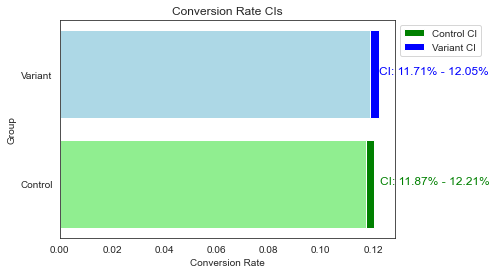

In [179]:
#Barplot for CI
fig, ax = plt.subplots()

#Stacked horizontal bar graphs for control and variant
ax.barh('Control', LB_0, color='lightgreen')
ax.barh('Control', UB_0-LB_0, label = 'Control CI', left=LB_0, color='green')
ax.barh('Variant', LB_1, color='lightblue')
ax.barh('Variant', UB_1-LB_1, label = 'Variant CI', left=LB_1, color='blue')

#Setting labels
ax.set_ylabel('Group')
ax.set_xlabel('Conversion Rate')
ax.set_title('Conversion Rate CIs')

#Adding custom text values
ax.text(UB_0+0.0017, 1, f'CI: {round(LB_0*100,2)}% - {round(UB_0*100,2)}%', fontsize=12, color='blue')
ax.text(UB_1+0.0007, 0, f'CI: {round(LB_1*100,2)}% - {round(UB_1*100,2)}%', fontsize=12, color='green')

#Moving legend location outside 
_=ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Checking Chi-square test statistic with Z-test

In [184]:
#Z-test checker
##Two proportion z-test, on-tailed
from statsmodels.stats.proportion import proportions_ztest
count = np.array([df_crosstab[1][0], df_crosstab[1][1]])
nobs = np.array([df_crosstab[0][0]+df_crosstab[1][0], df_crosstab[0][1]+df_crosstab[1][1]])
stat, pval = proportions_ztest(count, nobs, alternative = 'smaller')
print('{0:0.3f}'.format(pval))
print(pval)

0.095
0.09494168724097551


In [185]:
#Z-test checker
##Two proportion z-test, two-tailed
from statsmodels.stats.proportion import proportions_ztest
count = np.array([df_crosstab[1][0], df_crosstab[1][1]])
nobs = np.array([df_crosstab[0][0]+df_crosstab[1][0], df_crosstab[0][1]+df_crosstab[1][1]])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))
print(pval)

0.190
0.18988337448195103


In [187]:
#Checking equivalence of the test statistic values from the chi square and z-tests
assert pval == p

AssertionError: 

In [190]:
#We can see we did not get an exact match, but rounded to 10 places they are the same
assert round(pval,10) == round(p,10)